# Advanced SMS Spam Detection with DistilBERT

This notebook implements a comprehensive SMS spam detection system using advanced preprocessing techniques and DistilBERT fine-tuning. The implementation follows best practices for mobile deployment and includes hyperparameter optimization.

## 1. Setup and Dependencies

First, we'll install and import all required libraries for our SMS spam detection pipeline.

In [15]:
# Install required packages
!pip install transformers torch pandas numpy scikit-learn optuna nltk spacy emoji regex tqdm matplotlib seaborn

In [16]:
# Import required libraries
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW  # Import AdamW from torch.optim instead of transformers
from transformers import (
    DistilBertTokenizer,
    DistilBertModel,
    get_linear_schedule_with_warmup
)
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    roc_auc_score, confusion_matrix
)
import optuna
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import emoji
import logging
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt_tab') # Added this line to download the missing resource

Using device: cuda


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## 2. Load and Explore SMS Data

We'll load the SMS dataset and perform initial exploration to understand its characteristics.

In [19]:
# Load the first dataset
df1 = pd.read_csv("/content/spam (1).csv", encoding='latin1')

# Load the second dataset
df2 = pd.read_csv("/content/combined_dataset.csv", encoding='latin1') # Assuming the same encoding

# Merge the two datasets
df = pd.concat([df1, df2], ignore_index=True)

# Display the shape and head of the merged dataset
print("Merged dataset shape:", df.shape)
print("\nFirst few rows of merged dataset:")
display(df.head())

Merged dataset shape: (16533, 7)

First few rows of merged dataset:


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4,target,text
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN,NaN,NaN


In [20]:
# Basic data exploration
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head(10))

# Class distribution
print("\nClass distribution:")
print(df['v1'].value_counts(normalize=True))

# Basic statistics
print("\nMessage length statistics:")
df['length'] = df['v2'].str.len()
print(df.groupby('v1')['length'].describe())

Dataset shape: (16533, 7)

First few rows:
     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   
5  spam  FreeMsg Hey there darling it's been 3 week's n...        NaN   
6   ham  Even my brother is not like to speak with me. ...        NaN   
7   ham  As per your request 'Melle Melle (Oru Minnamin...        NaN   
8  spam  WINNER!! As a valued network customer you have...        NaN   
9  spam  Had your mobile 11 months or more? U R entitle...        NaN   

  Unnamed: 3 Unnamed: 4 target text  
0        NaN        NaN    NaN  NaN  
1        NaN        NaN    NaN  NaN  
2        NaN        NaN    NaN  NaN  
3

## 3. Text Preprocessing Pipeline

Implementing a comprehensive preprocessing pipeline specifically designed for SMS data.

In [23]:
class SMSPreprocessor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))

        # Common SMS abbreviations
        self.sms_dict = {
            "u": "you", "ur": "your", "2": "to", "4": "for",
            "b4": "before", "gr8": "great", "luv": "love",
            "msg": "message", "txt": "text", "asap": "as soon as possible"
        }

    def preprocess(self, text):
        """
        Complete preprocessing pipeline for SMS messages
        """
        # Ensure text is a string and handle potential NaNs
        text = str(text) if pd.notna(text) else ""

        # Stage 1: Initial Text Cleaning
        text = self._initial_cleaning(text)

        # Stage 2: SMS-Specific Preprocessing
        text = self._sms_specific_preprocessing(text)

        # Stage 3: Advanced Linguistic Processing
        text = self._linguistic_processing(text)

        return text

    def _initial_cleaning(self, text):
        # Convert to lowercase
        text = text.lower()

        # Replace URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '<url>', text, flags=re.MULTILINE)

        # Replace email addresses
        text = re.sub(r'\S+@\S+', '<email>', text)

        # Replace phone numbers
        text = re.sub(r'\+?[1-9][0-9\-\(\)]{8,}', '<phone>', text)

        # Handle emoji
        text = emoji.replace_emoji(text, '<emoji>')

        # Normalize whitespace
        text = ' '.join(text.split())

        return text

    def _sms_specific_preprocessing(self, text):
        # Expand abbreviations
        words = text.split()
        words = [self.sms_dict.get(word, word) for word in words]
        text = ' '.join(words)

        # Handle repeated characters (e.g., "sooooo" → "so")
        text = re.sub(r'(.)\1{2,}', r'\1\1', text)

        # Normalize numbers
        text = re.sub(r'\$\d+(\.\d{2})?', '<money>', text)
        text = re.sub(r'\d+%', '<percentage>', text)

        return text

    def _linguistic_processing(self, text):
        # Tokenization
        tokens = word_tokenize(text)

        # Selective stop word removal (keep potentially important ones)
        important_stops = {'not', 'no', 'never', 'none', 'free', 'click'}
        tokens = [token for token in tokens if token not in self.stop_words or token in important_stops]

        # Light lemmatization (only for verbs and nouns)
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens]

        return ' '.join(tokens)

# Initialize preprocessor
preprocessor = SMSPreprocessor()

# Apply preprocessing to the dataset
df['processed_text'] = df['v2'].apply(preprocessor.preprocess)

# Show some examples
print("Original vs Processed Text Examples:")
for i in range(3):
    print(f"\nOriginal: {df['v2'].iloc[i]}")
    print(f"Processed: {df['processed_text'].iloc[i]}")

Original vs Processed Text Examples:

Original: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Processed: go jurong point , crazy .. available bugis n great world la e buffet .. cine got amore wat ..

Original: Ok lar... Joking wif u oni...
Processed: ok lar .. joking wif oni ..

Original: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
Processed: free entry wkly comp win fa cup final tkts 21st may 2005. text fa 87121 receive entry question ( std text rate ) & c 's apply 0 < phone > over18 's


## 4. Build DistilBERT Model

Now we'll create our custom model architecture using DistilBERT as the base model.

In [24]:
class SMSSpamClassifier(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(SMSSpamClassifier, self).__init__()

        # Load pre-trained DistilBERT
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')

        # Freeze some layers for efficiency (optional)
        for param in self.distilbert.parameters():
            param.requires_grad = False

        # Unfreeze the last 2 transformer layers
        for layer in self.distilbert.transformer.layer[-2:]:
            for param in layer.parameters():
                param.requires_grad = True

        # Classification head
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(self.distilbert.config.hidden_size, 2)

        # Ensure model parameters are float32
        self.to(torch.float32)

        # Attention visualization layer
        self.attention_weights = None

    def forward(self, input_ids, attention_mask):
        # Get DistilBERT outputs
        outputs = self.distilbert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_attentions=True
        )

        # Get the [CLS] token representation
        cls_output = outputs.last_hidden_state[:, 0, :]

        # Store attention weights for visualization
        self.attention_weights = outputs.attentions[-1]  # Last layer's attention

        # Apply dropout and classification
        x = self.dropout(cls_output)
        logits = self.classifier(x)

        return logits

    def get_attention_weights(self):
        return self.attention_weights

# Initialize tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = SMSSpamClassifier().to(device)

print("Model architecture:")
print(model)

Model architecture:
SMSSpamClassifier(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False

## 5. Training Configuration

Set up the training parameters, loss function, optimizer, and learning rate scheduler.

In [25]:
# Create PyTorch Dataset
class SMSDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Tokenize text
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        # Ensure float32 type for input tensors
        return {
            'input_ids': encoding['input_ids'].flatten().to(torch.long),  # Use long for input_ids
            'attention_mask': encoding['attention_mask'].flatten().to(torch.float32),  # Use float32 for attention_mask
            'label': torch.tensor(label, dtype=torch.long)  # Use long for labels
        }

# Prepare data splits
X = df['processed_text'].values
y = (df['v1'] == 'spam').astype(int).values

# Create stratified train, validation, and test splits
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.15/0.85, stratify=y_temp, random_state=42
)

# Create datasets
train_dataset = SMSDataset(X_train, y_train, tokenizer)
val_dataset = SMSDataset(X_val, y_val, tokenizer)
test_dataset = SMSDataset(X_test, y_test, tokenizer)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Training configuration
config = {
    'learning_rate': 2e-5,
    'num_epochs': 3,
    'warmup_steps': 0.1,  # 10% of total steps
    'weight_decay': 0.01,
    'gradient_clipping': 1.0
}

# Calculate total steps for warmup
total_steps = len(train_loader) * config['num_epochs']
warmup_steps = int(total_steps * config['warmup_steps'])

# Initialize optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

# Initialize loss function with class weights to handle imbalance
# Ensure class weights are float32
class_weights = torch.tensor(
    [1.0, (y_train == 0).sum() / (y_train == 1).sum()],
    device=device,
    dtype=torch.float32  # Explicitly set dtype to float32
)
criterion = nn.CrossEntropyLoss(weight=class_weights)

print("Training configuration:")
print(f"Number of training examples: {len(train_dataset)}")
print(f"Number of validation examples: {len(val_dataset)}")
print(f"Number of test examples: {len(test_dataset)}")
print(f"Number of training steps: {total_steps}")
print(f"Number of warmup steps: {warmup_steps}")
print(f"Class weights: {class_weights.cpu().numpy()}")

Training configuration:
Number of training examples: 11573
Number of validation examples: 2480
Number of test examples: 2480
Number of training steps: 2172
Number of warmup steps: 217
Class weights: [ 1.       21.128107]


## 6. Model Training and Validation

Implement the training loop with early stopping and evaluation.

In [26]:
def train_epoch(model, train_loader, criterion, optimizer, scheduler, clip_value=1.0):
    model.train()
    total_loss = 0
    predictions = []
    true_labels = []

    progress_bar = tqdm(train_loader, desc='Training')
    for batch in progress_bar:
        # Get batch data
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()
        scheduler.step()

        # Update metrics
        total_loss += loss.item()
        predictions.extend(outputs.argmax(dim=1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

        # Update progress bar
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

    avg_loss = total_loss / len(train_loader)
    accuracy = accuracy_score(true_labels, predictions)

    return avg_loss, accuracy

def evaluate(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            predictions.extend(outputs.argmax(dim=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(val_loader)
    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, predictions, average='binary'
    )

    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': predictions,
        'true_labels': true_labels
    }

# Training loop with early stopping
best_val_loss = float('inf')
early_stopping_patience = 3
early_stopping_counter = 0
training_history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [],
    'val_f1': []
}

for epoch in range(config['num_epochs']):
    print(f"\nEpoch {epoch + 1}/{config['num_epochs']}")

    # Training phase
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer,
        scheduler, config['gradient_clipping']
    )

    # Validation phase
    val_metrics = evaluate(model, val_loader, criterion)

    # Update training history
    training_history['train_loss'].append(train_loss)
    training_history['train_acc'].append(train_acc)
    training_history['val_loss'].append(val_metrics['loss'])
    training_history['val_acc'].append(val_metrics['accuracy'])
    training_history['val_f1'].append(val_metrics['f1'])

    # Print epoch results
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_metrics['loss']:.4f} | Val Acc: {val_metrics['accuracy']:.4f}")
    print(f"Val Precision: {val_metrics['precision']:.4f} | Val Recall: {val_metrics['recall']:.4f}")
    print(f"Val F1: {val_metrics['f1']:.4f}")

    # Early stopping
    if val_metrics['loss'] < best_val_loss:
        best_val_loss = val_metrics['loss']
        torch.save(model.state_dict(), 'best_model.pt')
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break

print("\nTraining completed!")


Epoch 1/3


Training:   0%|          | 0/724 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/78 [00:00<?, ?it/s]

Train Loss: 0.1703 | Train Acc: 0.9552
Val Loss: 0.0917 | Val Acc: 0.9940
Val Precision: 0.9217 | Val Recall: 0.9464
Val F1: 0.9339

Epoch 2/3


Training:   0%|          | 0/724 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/78 [00:00<?, ?it/s]

Train Loss: 0.0689 | Train Acc: 0.9967
Val Loss: 0.0850 | Val Acc: 0.9960
Val Precision: 0.9554 | Val Recall: 0.9554
Val F1: 0.9554

Epoch 3/3


Training:   0%|          | 0/724 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/78 [00:00<?, ?it/s]

Train Loss: 0.0525 | Train Acc: 0.9975
Val Loss: 0.0722 | Val Acc: 0.9964
Val Precision: 0.9558 | Val Recall: 0.9643
Val F1: 0.9600

Training completed!


## 7. Hyperparameter Optimization

Use Optuna for systematic hyperparameter tuning.

In [27]:
def objective(trial):
    # Hyperparameters to optimize
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 5e-5, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [8, 16, 32]),
        'dropout_rate': trial.suggest_float('dropout_rate', 0.1, 0.5),
        'weight_decay': trial.suggest_float('weight_decay', 0.01, 0.1),
        'warmup_steps': trial.suggest_float('warmup_steps', 0.1, 0.3)
    }

    # Create model with trial parameters
    model = SMSSpamClassifier(dropout_rate=params['dropout_rate']).to(device)

    # Create data loaders with trial batch size
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)

    # Training setup
    total_steps = len(train_loader) * config['num_epochs']
    warmup_steps = int(total_steps * params['warmup_steps'])

    optimizer = AdamW(
        model.parameters(),
        lr=params['learning_rate'],
        weight_decay=params['weight_decay']
    )

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )

    # Training loop
    best_val_f1 = 0
    for epoch in range(config['num_epochs']):
        # Training phase
        train_loss, _ = train_epoch(
            model, train_loader, criterion, optimizer,
            scheduler, config['gradient_clipping']
        )

        # Validation phase
        val_metrics = evaluate(model, val_loader, criterion)

        # Report intermediate value
        trial.report(val_metrics['f1'], epoch)

        # Handle pruning based on the intermediate value
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        best_val_f1 = max(best_val_f1, val_metrics['f1'])

    return best_val_f1

# Create study object and specify the direction is 'maximize' the F1 score
study = optuna.create_study(direction='maximize')

# Run hyperparameter optimization
print("Running hyperparameter optimization...")
study.optimize(objective, n_trials=10)

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Plot optimization history
optuna.visualization.plot_optimization_history(study)
optuna.visualization.plot_param_importances(study)

[I 2025-10-16 19:18:27,956] A new study created in memory with name: no-name-379da70c-a973-4f44-b362-3b258d3263a6


Running hyperparameter optimization...


Training:   0%|          | 0/724 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/155 [00:00<?, ?it/s]

Training:   0%|          | 0/724 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/155 [00:00<?, ?it/s]

Training:   0%|          | 0/724 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/155 [00:00<?, ?it/s]

[I 2025-10-16 19:22:30,271] Trial 0 finished with value: 0.9596412556053812 and parameters: {'learning_rate': 1.8230195297560018e-05, 'batch_size': 16, 'dropout_rate': 0.3484691792847845, 'weight_decay': 0.09265608608351773, 'warmup_steps': 0.2501861546744401}. Best is trial 0 with value: 0.9596412556053812.


Training:   0%|          | 0/724 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/155 [00:00<?, ?it/s]

Training:   0%|          | 0/724 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/155 [00:00<?, ?it/s]

Training:   0%|          | 0/724 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/155 [00:00<?, ?it/s]

[I 2025-10-16 19:26:23,316] Trial 1 finished with value: 0.9642857142857143 and parameters: {'learning_rate': 2.8501160443411365e-05, 'batch_size': 16, 'dropout_rate': 0.46800218843255403, 'weight_decay': 0.015761921388216218, 'warmup_steps': 0.16418701138273215}. Best is trial 1 with value: 0.9642857142857143.


Training:   0%|          | 0/362 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/78 [00:00<?, ?it/s]

Training:   0%|          | 0/362 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/78 [00:00<?, ?it/s]

Training:   0%|          | 0/362 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/78 [00:00<?, ?it/s]

[I 2025-10-16 19:30:01,220] Trial 2 finished with value: 0.9642857142857143 and parameters: {'learning_rate': 3.2117060000034174e-05, 'batch_size': 32, 'dropout_rate': 0.17532686783974905, 'weight_decay': 0.03840211974790241, 'warmup_steps': 0.13681927826747584}. Best is trial 1 with value: 0.9642857142857143.


Training:   0%|          | 0/362 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/78 [00:00<?, ?it/s]

Training:   0%|          | 0/362 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/78 [00:00<?, ?it/s]

Training:   0%|          | 0/362 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/78 [00:00<?, ?it/s]

[I 2025-10-16 19:33:39,092] Trial 3 finished with value: 0.956140350877193 and parameters: {'learning_rate': 1.5847048702524584e-05, 'batch_size': 32, 'dropout_rate': 0.30908326833448396, 'weight_decay': 0.019582847146219128, 'warmup_steps': 0.11097494173701927}. Best is trial 1 with value: 0.9642857142857143.


Training:   0%|          | 0/724 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/155 [00:00<?, ?it/s]

Training:   0%|          | 0/724 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/155 [00:00<?, ?it/s]

Training:   0%|          | 0/724 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/155 [00:00<?, ?it/s]

[I 2025-10-16 19:37:32,163] Trial 4 finished with value: 0.9773755656108597 and parameters: {'learning_rate': 3.712159080760728e-05, 'batch_size': 16, 'dropout_rate': 0.3664084717352821, 'weight_decay': 0.07717470818527356, 'warmup_steps': 0.27507966518153404}. Best is trial 4 with value: 0.9773755656108597.


Training:   0%|          | 0/362 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/78 [00:00<?, ?it/s]

[I 2025-10-16 19:38:45,275] Trial 5 pruned. 


Training:   0%|          | 0/1447 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/310 [00:00<?, ?it/s]

Training:   0%|          | 0/1447 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/310 [00:00<?, ?it/s]

[I 2025-10-16 19:41:31,577] Trial 6 pruned. 


Training:   0%|          | 0/724 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/155 [00:00<?, ?it/s]

[I 2025-10-16 19:42:49,771] Trial 7 pruned. 


Training:   0%|          | 0/724 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/155 [00:00<?, ?it/s]

Training:   0%|          | 0/724 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/155 [00:00<?, ?it/s]

Training:   0%|          | 0/724 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/155 [00:00<?, ?it/s]

[I 2025-10-16 19:46:43,156] Trial 8 finished with value: 0.9642857142857143 and parameters: {'learning_rate': 4.2106320280748835e-05, 'batch_size': 16, 'dropout_rate': 0.3759233607290674, 'weight_decay': 0.09080079131641046, 'warmup_steps': 0.25570983817129933}. Best is trial 4 with value: 0.9773755656108597.


Training:   0%|          | 0/1447 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/310 [00:00<?, ?it/s]

[I 2025-10-16 19:48:06,780] Trial 9 pruned. 


Best trial:
  Value:  0.9773755656108597
  Params: 
    learning_rate: 3.712159080760728e-05
    batch_size: 16
    dropout_rate: 0.3664084717352821
    weight_decay: 0.07717470818527356
    warmup_steps: 0.27507966518153404


## 8. Evaluation and Visualization

Calculate metrics and visualize model performance.

Evaluating:   0%|          | 0/78 [00:00<?, ?it/s]


Test Set Metrics:
Accuracy: 0.9984
Precision: 0.9821
Recall: 0.9821
F1 Score: 0.9821


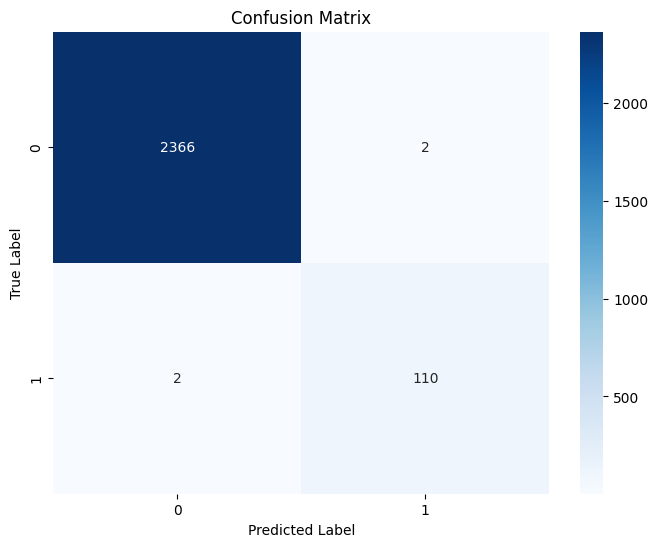

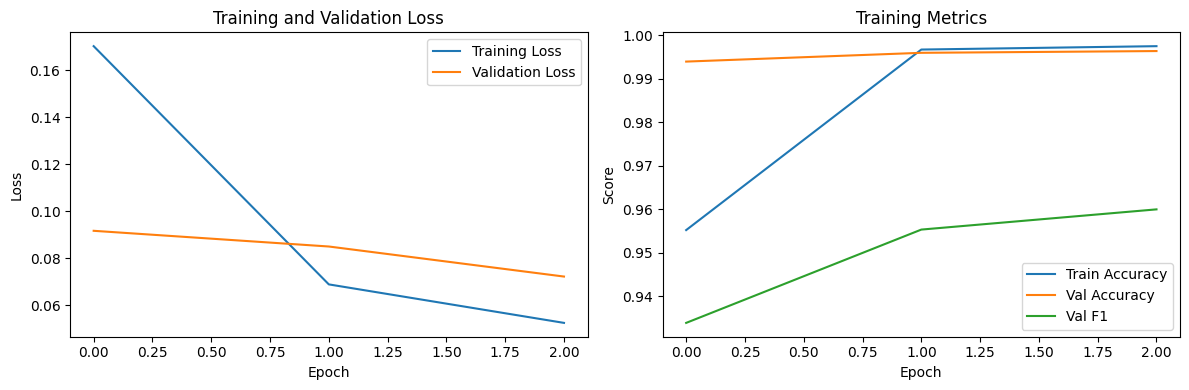

Sample text: six chance win cash ! 100 20,00 pound txt > csh11 send 87575. cost 150p/day , 6days , 16+ tsandcs apply reply hl info


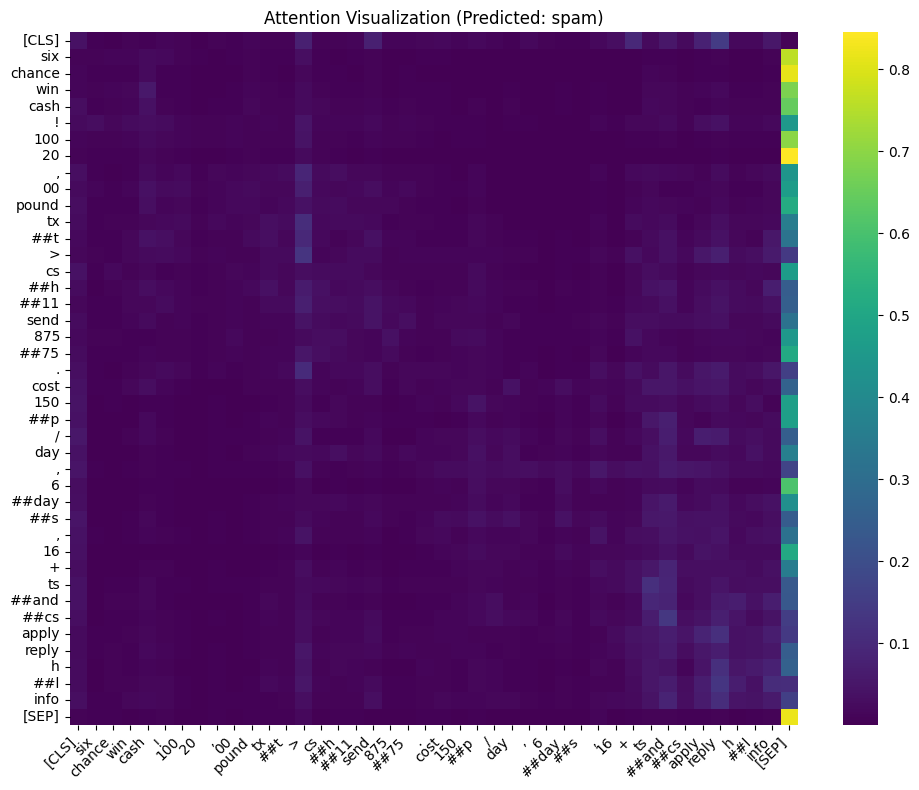

In [28]:
# Load best model
model.load_state_dict(torch.load('best_model.pt'))

# Evaluate on test set
test_metrics = evaluate(model, test_loader, criterion)

# Print final metrics
print("\nTest Set Metrics:")
print(f"Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall: {test_metrics['recall']:.4f}")
print(f"F1 Score: {test_metrics['f1']:.4f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(test_metrics['true_labels'], test_metrics['predictions'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot training history
plt.figure(figsize=(12, 4))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(training_history['train_loss'], label='Training Loss')
plt.plot(training_history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot metrics
plt.subplot(1, 2, 2)
plt.plot(training_history['train_acc'], label='Train Accuracy')
plt.plot(training_history['val_acc'], label='Val Accuracy')
plt.plot(training_history['val_f1'], label='Val F1')
plt.title('Training Metrics')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()

# Attention visualization for a sample message
def visualize_attention(model, tokenizer, text):
    # Tokenize and prepare input
    encoding = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        padding=True,
        max_length=128
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Get model prediction and attention weights
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        attention = model.get_attention_weights()

    # Get prediction
    pred = outputs.argmax(dim=1).item()

    # Get tokens
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

    # Plot attention heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        attention[0][0].cpu(),
        xticklabels=tokens,
        yticklabels=tokens,
        cmap='viridis'
    )
    plt.title(f'Attention Visualization (Predicted: {"spam" if pred == 1 else "ham"})')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Visualize attention for a sample spam message
sample_text = X_test[y_test == 1][0]  # Get a spam message
print("Sample text:", sample_text)
visualize_attention(model, tokenizer, sample_text)

In [58]:
import torch.nn.functional as F

def predict_spam_manual(text, model, tokenizer, preprocessor, device, max_length=128):
    # Preprocess the text
    processed_text = preprocessor.preprocess(text)

    # Tokenize the processed text
    encoding = tokenizer(
        processed_text,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='pt'
    )

    # Move tensors to device
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Get model prediction
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        logits = outputs.squeeze() # Remove batch dimension

    # Apply softmax to get probabilities
    probabilities = F.softmax(logits, dim=-1)

    # Get predicted class and confidence
    predicted_class_id = probabilities.argmax(dim=-1).item()
    confidence = probabilities[predicted_class_id].item() * 100

    return 'spam' if predicted_class_id == 1 else 'ham', confidence, probabilities.cpu().numpy()

# Example usage:
sample_message_1 = "How are you my honey? i have no money please send me 1000$ instantly"
prediction_1, confidence_1, probabilities_1 = predict_spam_manual(
    sample_message_1, model, tokenizer, preprocessor, device
)
print(f"Message: '{sample_message_1}'")
print(f"Prediction: {prediction_1} (Confidence: {confidence_1:.2f}%)")
print(f"Probabilities: {probabilities_1}")


sample_message_2 = "Help victims of GAZA! Donate immediately to this account to save lives today!"
prediction_2, confidence_2, probabilities_2 = predict_spam_manual(
    sample_message_2, model, tokenizer, preprocessor, device
)
print(f"\nMessage: '{sample_message_2}'")
print(f"Prediction: {prediction_2} (Confidence: {confidence_2:.2f}%)")
print(f"Probabilities: {probabilities_2}")

Message: 'How are you my honey? i have no money please send me 1000$ instantly'
Prediction: ham (Confidence: 94.88%)
Probabilities: [0.9487918  0.05120825]

Message: 'Help victims of GAZA! Donate immediately to this account to save lives today!'
Prediction: spam (Confidence: 66.81%)
Probabilities: [0.3319383  0.66806173]


# Testing by synthetic dataset

In [75]:
# prepare this csv and test it
testing = pd.read_csv('/content/sms_spam_ham_dataset_100.csv', encoding='latin-1')
testing.head()


,message,label
0,Free trial of premium dating app! Find love: d...,spam
1,Your LinkedIn account has unusual activity: li...,spam
2,Thanks for the recommendation! I really enjoye...,ham
3,Get $200 cash back with new credit card: cashb...,spam
4,Can you send me the project report by EOD?,ham


In [76]:
testing.head()

,message,label
0,Free trial of premium dating app! Find love: d...,spam
1,Your LinkedIn account has unusual activity: li...,spam
2,Thanks for the recommendation! I really enjoye...,ham
3,Get $200 cash back with new credit card: cashb...,spam
4,Can you send me the project report by EOD?,ham


In [77]:
testing.drop(columns=['label'], inplace=True)

In [78]:
testing.head()

,message
0,Free trial of premium dating app! Find love: d...
1,Your LinkedIn account has unusual activity: li...
2,Thanks for the recommendation! I really enjoye...
3,Get $200 cash back with new credit card: cashb...
4,Can you send me the project report by EOD?


In [79]:
# Iterate through the messages in the testing dataset and make predictions
print("Real-time Predictions and Confidence:")
for index, row in testing.iterrows():
    original_message = row['message']
    # Ensure 'processed_text' column exists and is used if preprocessing was applied
    # If preprocessing was not applied yet, use the original message
    text_to_predict = row.get('processed_text', original_message)

    prediction, confidence, probabilities = predict_spam_manual(
        text_to_predict, model, tokenizer, preprocessor, device
    )

    print(f"\nMessage: '{original_message}'")
    print(f"Prediction: {prediction} (Confidence: {confidence:.2f}%)")
    # print(f"Probabilities: {probabilities}") # Optional: uncomment to see raw probabilities

Real-time Predictions and Confidence:

Message: 'Free trial of premium dating app! Find love: dating.fake/trial'
Prediction: spam (Confidence: 99.85%)

Message: 'Your LinkedIn account has unusual activity: linkedin.fake/security'
Prediction: spam (Confidence: 97.64%)

Message: 'Thanks for the recommendation! I really enjoyed the book'
Prediction: ham (Confidence: 98.31%)

Message: 'Get $200 cash back with new credit card: cashback.fake/card'
Prediction: spam (Confidence: 99.71%)

Message: 'Can you send me the project report by EOD?'
Prediction: ham (Confidence: 99.94%)

Message: 'Your email account will expire today. Renew: email.fake/renew'
Prediction: spam (Confidence: 81.16%)

Message: 'Your account has been suspended. Click here to reactivate: bit.ly/fake123'
Prediction: spam (Confidence: 99.97%)

Message: 'You've been selected for a free iPhone 15! Limited time: apple.fake/iphone'
Prediction: spam (Confidence: 99.93%)

Message: 'Urgent: Your Social Security number is suspended: ss

In [80]:
testing.head(10)

,message
0,Free trial of premium dating app! Find love: d...
1,Your LinkedIn account has unusual activity: li...
2,Thanks for the recommendation! I really enjoye...
3,Get $200 cash back with new credit card: cashb...
4,Can you send me the project report by EOD?
5,Your email account will expire today. Renew: e...
6,Your account has been suspended. Click here to...
7,You've been selected for a free iPhone 15! Lim...
8,Urgent: Your Social Security number is suspend...
9,Win a shopping spree worth $2000! Enter now: s...
